# LABORATORIUM 5 - Metody Bayesowskie

Importy:

In [168]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine, load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from math import fabs
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

Metody do wyznaczania accuracy oraz erroru dla przewidywanych klas, względem tych rzeczywistych.

In [56]:
def accuracy(pred, actual):
  return np.sum(pred == actual) / len(pred)

def error(pred, actual):
  return 1.0 - accuracy(pred, actual)

## Gaussowski Naiwny Klasyfikator Bayesa
### Zadanie 1, 2

Klasa NaiveBayesClassifier jest implementacją Naiwnego Klasyfikatora Bayesa. 

Metoda *fit* wylicza średnie, odchylenia standardowe dla cech dla każdej z danych klas (target).  Oblicza też prawdopodobieństwa prior dla każdej z danych klas.

Metoda *predict* dokonuje predykcji dla danych testowych - na podstawie prawdopodobieństwa posterior, korzystając z Twierdzenia Bayesa oraz funkcji wiarygodności (*gaussian*). 

Uwaga: Iloczyn zamieniłem na sumę logarytmów (lepsza stabilność numeryczna).


In [57]:
class NaiveBayesClassifier:
  def calc_means(self, train, target):
    self.means = train.groupby(target).apply(np.mean).to_numpy()

  def calc_vars(self, train, target):
    self.vars = train.groupby(target).apply(np.var).to_numpy()

  def calc_priors(self, train, target):
    self.priors = (train.groupby(target).apply(lambda x: len(x))/train.shape[0]).to_numpy()
  
  def gaussian(self, x, mean, var):
        a = np.exp((-1/2)*((x - mean[:-1])**2) / (2 * var[:-1]))
        b = np.sqrt(2 * np.pi * var[:-1])
        return a / b

  def posterior(self, x):
    posteriors = []
    for i in range(len(self.classes)):
        prior = np.log(self.priors[i])
        cond = np.sum(np.log(self.gaussian(x, self.means[i], self.vars[i])))
        posterior = prior + cond
        posteriors.append(posterior)
    return self.classes[np.argmax(posteriors)]
  
  # założenie: test - ostatnia kolumna to target
  def predict(self, test):
    return [self.posterior(x) for x in test.to_numpy()]

  def fit(self, train, target):
    self.calc_means(train, target)
    self.calc_vars(train, target)
    self.calc_priors(train, target)
    self.classes = np.unique(train[target])


### Zadanie 3

Zbiór *Irys* załadowałem za pomocą odpowiedniej metody z scikit-learn, skorzystałem też z metody *train_test_split* z tej samej biblioteki do podziału danych na treningowe oraz testowe. 

In [58]:
df = load_iris(as_frame=True)

In [59]:
errors = []
for _ in range(20):
  train, test = train_test_split(df['frame'], test_size=0.4)
  X_test, y_test = test.drop(columns=['target']), test['target']
  cls = NaiveBayesClassifier()
  cls.fit(train, 'target')
  predictions = cls.predict(X_test)
  errors.append(error(predictions, y_test))
print("Mean error:", np.mean(errors))
print("Error var:", np.var(errors))

Mean error: 0.037500000000000026
Error var: 0.00032986111111111096


### Zadanie 4

Analogicznie jak wyżej. Oprócz tego użyto *StandardScaler* do standaryzacji danych wejściowych, oraz *PCA*. Obie klasy z scikit-learn.

In [60]:
df = load_wine(as_frame=True)

In [61]:
scaler = StandardScaler()

In [62]:
df_scaled = pd.DataFrame(scaler.fit_transform(df['frame'].drop(columns=['target'])), columns=df['frame'].drop(columns=['target']).columns).join(df['frame']['target'])

In [63]:
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit(df['frame'].drop(columns=['target'])).transform(df['frame'].drop(columns=['target'])), columns=['feature1', 'feature2']).join(df['frame']['target'])

In [64]:
df_pca_scaled = pd.DataFrame(pca.fit(df_scaled.drop(columns=['target'])).transform(df_scaled.drop(columns=['target'])), columns=['feature1', 'feature2']).join(df_scaled['target'])

In [65]:
def test_classification_wine(df):
  accuracies = []
  for _ in range(20):
    train, test = train_test_split(df, test_size=0.3)
    X_test, y_test = test.drop(columns=['target']), test['target']
    cls = NaiveBayesClassifier()
    cls.fit(train, 'target')
    predictions = cls.predict(X_test)
    accuracies.append(accuracy(predictions, y_test))
  return np.mean(accuracies), np.var(accuracies)

In [66]:
test_classification_wine(df_scaled)

(0.9546296296296294, 0.00039351851851851885)

In [67]:
test_classification_wine(df['frame'])

(0.9518518518518517, 0.0007681755829903982)

In [68]:
test_classification_wine(df_pca)

(0.7435185185185185, 0.0025471536351165973)

In [69]:
test_classification_wine(df_pca_scaled)

(0.9759259259259258, 0.0002777777777777783)

Najlepszy wynik dało ustandaryzowanie danych + redukcja wymiarowości (PCA).

Samo PCA działo bardzo słabo.

Skalowanie zmniejsza wariancję accuracy, ale w tym przypadku daje podobny wynik, jak brak skalowania.

### Zadanie 5

Transformacja Box-Cox.

In [70]:
boxcox_df = pd.DataFrame([])
tmp_df = df['frame'].drop(columns=['target'])
for column in tmp_df.columns:
  transformed = pd.DataFrame(stats.boxcox(tmp_df[column])[0], columns=[column])
  boxcox_df=transformed.join(boxcox_df)
boxcox_df=boxcox_df.join(df['frame']['target'])  

In [71]:
test_classification_wine(boxcox_df)

(0.9601851851851849, 0.00038665980795610466)

Uzyskano najlepszy wynik względem wcześniejszych metod.

## Liniowa Regresja Bayesowska online

### Zadanie 1

In [83]:
class BayesianLinearRegression:
  def __init__(self, n_features, alpha, beta):
    self.n_features = n_features
    self.alpha = alpha
    self.beta = beta
    self.mean = np.zeros(n_features)
    self.cov = np.identity(n_features) * alpha

  def learn(self, x, y):
    cov_inv = np.linalg.inv(self.cov)
    self.cov = np.linalg.inv(cov_inv + self.beta * x.T @ x)
    self.mean = self.cov @ (cov_inv @ self.mean + self.beta * x.T @ y)
    return self

  def predict(self, x):
    y_pred_mean = self.mean.T @ x
    y_pred_var = 1 / self.beta + x.T @ self.cov @ x
    
    return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

  @property
  def weights_dist(self):
    return stats.multivariate_normal(mean=self.mean, cov=self.cov)

### Zadanie 2

In [158]:
df = load_boston()
data = df['data']
target = df['target']
n_features = len(data[0])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [165]:
blr = BayesianLinearRegression(n_features, 0.3, 1.0)

errs = []

preds = []

for i in range(len(data)):
  blr.learn(np.array([data[i]]), np.array([target[i]]))
  pred = blr.predict(data[i]).mean()
  preds.append(pred)
  actual = target[i]
  errs.append(fabs(pred - actual))

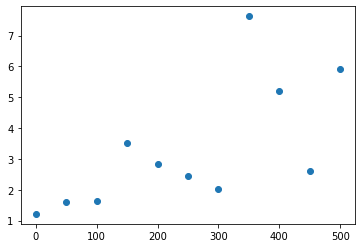

In [170]:
step = 50

errs_mean = []

actual = []
for err in errs:
  actual.append(err)
  if len(actual) == step:
    errs_mean.append(sum(actual)/len(actual))
    actual = []

errs_mean.append(sum(actual)/len(actual))

plt.scatter(range(0, len(data), step), errs_mean)
plt.show()

Powyżej przedstawiono średnią krokową dla kolejnych błędów bezwzględnych, widać, że model uzyskał całkiem niezłą dokładność.

Poniżej przedstawiono wartość metryki R2.

In [167]:
r2_score(target, preds)

0.7495096908917207

### Zadanie 3

In [174]:
def t_noise(x):
  return -0.2 + 0.6 * x + np.random.normal(0.0, 0.2)

def t(x):
  return -0.2 + 0.6 * x

In [175]:
xs = np.random.uniform(size=10) * 2 - 1
ys = [t(x) for x in xs]
ys_noise = [t_noise(x) for x in xs]
data = list(zip(xs, ys_noise))

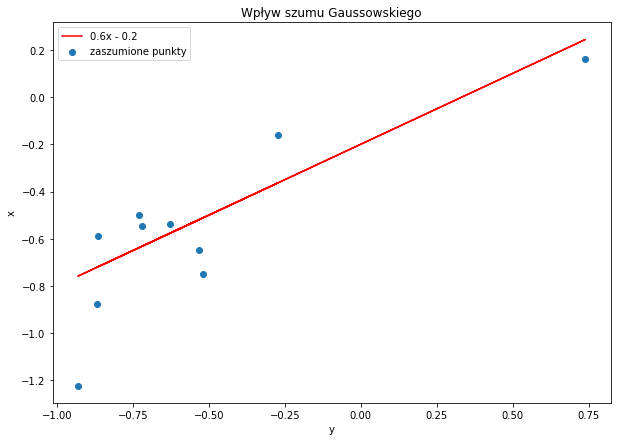

In [176]:
plt.figure(figsize=(10,7))
plt.plot(xs, ys, color='r', label="0.6x - 0.2")
plt.scatter(xs, ys_noise, label="zaszumione punkty")
plt.xlabel("y")
plt.ylabel("x")
plt.title("Wpływ szumu Gaussowskiego")
plt.legend();

### Zadanie 4

In [177]:
def plot_distribution(blr, title):
  x, y = np.mgrid[-1.:1.:.01, -1.:1.:.01]
  pos = np.dstack((x, y))
  plt.contourf(x, y, blr.weights_dist.pdf(pos), levels=15)
  plt.title(title)
  plt.xlabel("w1")
  plt.ylabel("w2")
  plt.plot(-0.2, 0.6, 'o', color='r')
  plt.show()

In [178]:
def plot_predictive_distribution(blr, title, data):
  plt.plot([-1, 1], [-0.8, 0.4], color='b')
  X = list(map(lambda x: x[0], data))
  Y = list(map(lambda x: x[1], data))


  space = np.linspace(-1, 1, 100)
  y1 = []
  y2 = []
  for x in space:
    norm = blr.predict(np.array([1, x]))
    pred = norm.mean()
    std = norm.std()
    y1.append(pred + std)
    y2.append(pred - std)

  plt.fill_between(space, y1, y2, alpha=0.2)
  plt.scatter(X, Y, color='r')

  plt.show()

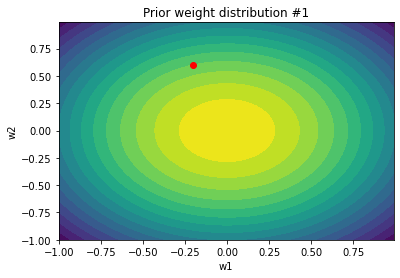

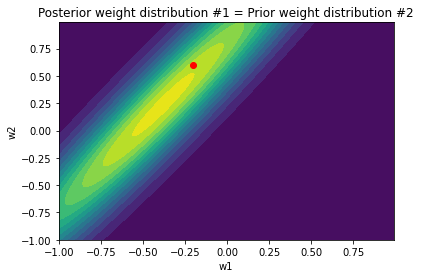

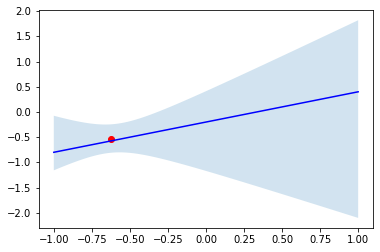

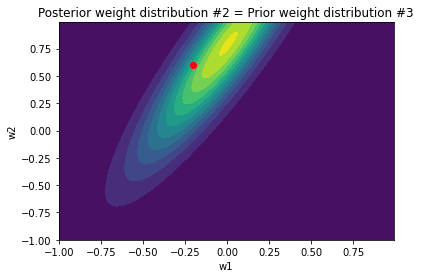

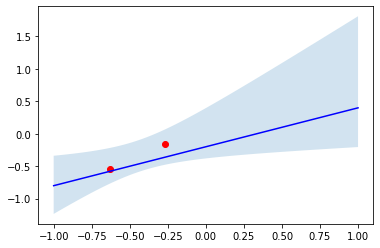

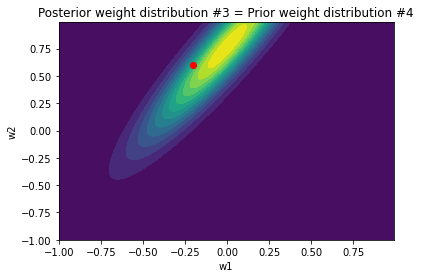

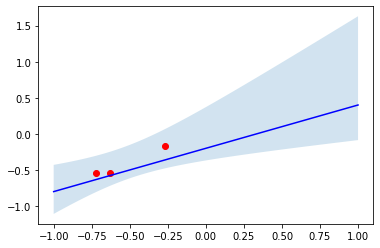

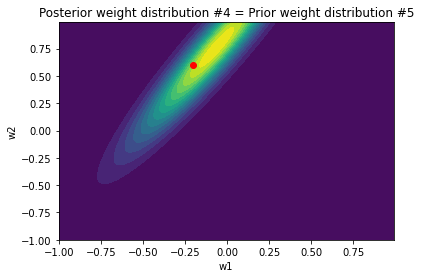

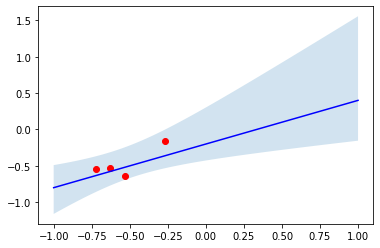

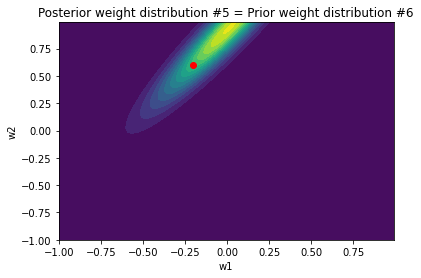

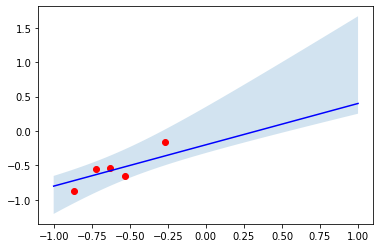

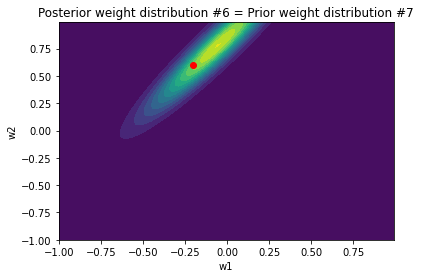

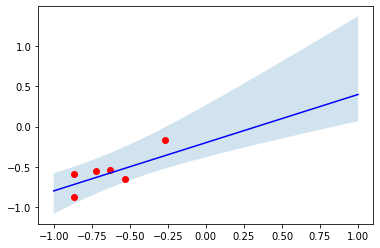

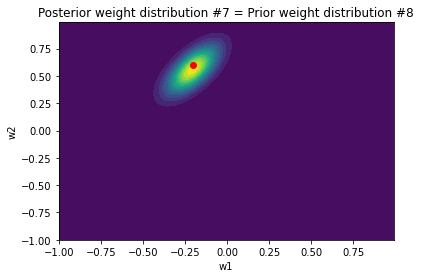

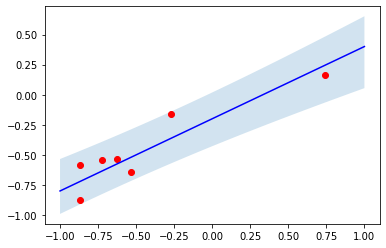

In [179]:
blr = BayesianLinearRegression(2, 2, 25)

plot_distribution(blr, f"Prior weight distribution #{1}")

for idx, d in enumerate(data[:7]):
  blr.learn(np.array([np.array([1,d[0]])]), np.array([d[1]]))
  plot_distribution(blr, f"Posterior weight distribution #{idx + 1} = Prior weight distribution #{idx + 2}")
  plot_predictive_distribution(blr, f"Posterior target distribution #{idx + 1}", data[:idx+1])
  print("\n")


### Zadanie 5

Rozkład posterior coraz bardziej się zawęża i skupia wokół szukanych współczynników w1, w2 (czerwony punkt).

## Naiwny Klasyfikator Bayesa z rozkładem Bernoulliego

Brak rozwiązania.